<a href="https://colab.research.google.com/github/ayexhs/Predictive-Analysis/blob/main/test_summariser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install Transformers if not installed
!pip install transformers


In [3]:
# Load Pre-Trained Summarization Model (BART)
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

Device set to use cpu


In [4]:
# Define Large Article
ARTICLE = """
You don’t always have to give your boss the finger
Maybe it’s your first day on the job. Perhaps your manager just made an announcement. You’ve been asked to scan your fingerprint every time you clock in and out. Is that even allowed?
From Hooters to Hyatt Hotels, employers tantalized by the promise of a futuristic, streamlined way to track workers’ attendance are starting to use time clock machines that fingerprint employees.
Vendors like Kronos and Allied Time say that because the machines are tied to your biometric information — unique characteristics such as your face, fingerprints, how you talk, and even how you walk — they provide a higher level of workplace security and limit employees’ ability to commit “time theft” by punching in for one another.
But the benefits for your boss may come at a cost to you — both your privacy and possibly your health.
With the global outbreak of COVID-19, your personal health could be at risk when using frequently touched screens and fingerprint scanners. The Centers for Disease Control says that coronavirus can remain on surfaces for hours, so screens and scanners should be regularly disinfected with cleaning spray or wipes. And you should wash your hands for 20 seconds or use alcohol-based hand sanitizer immediately after using one.
In addition to these health concerns, critics argue that biometric devices pose massive personal security issues, exposing workers to potential identity theft and subjecting them to possible surveillance from corporations and law enforcement.
In an amicus brief in a case before a federal court of appeals, a group of privacy advocates, including the ACLU and the EFF, wrote that “the immutability of biometric information” puts people “at risk of irreparable harm in the form of identity theft and/or tracking.”
“You can get a new phone, you can change your password, you can even change your Social Security number; you can’t change your face,” said Kade Crockford, the Technology for Liberty program director at ACLU of Massachusetts.
Companies facing legal action over their use of the machines range from fast food joints like McDonald’s and Wendy’s, to hotel chains like Marriott and Hyatt, to airlines like United and Southwest.
In some cases, the companies have countered in the lawsuits that their employees’ union agreement allows the use of the machines: “Southwest and United contend that the plaintiffs’ unions have consented — either expressly or through the collective bargaining agreements’ management-rights clauses — and that any required notice has been provided to the unions,” the court’s opinion states.
Other companies have not responded to requests for comment or have said they cannot comment on active litigation.
Privacy and labor laws have lagged behind the shifts in the American workplace. But in some places, you have the right to refuse and even sue.

Biometric Privacy Laws
As the collection and use of biometrics has exploded, lawmakers in three states have responded by passing laws restricting its deployment.
"""


In [5]:
# Check if Article Exceeds Token Limit (1024 for BART)
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
tokens = tokenizer(ARTICLE, return_tensors="pt", truncation=True, max_length=1024)
print("Token Length:", len(tokens['input_ids'][0]))

Token Length: 641


In [6]:
# Summarize Text
summary = summarizer(ARTICLE, max_length=130, min_length=30, do_sample=False)

In [7]:
# Print Summary Output
print("\nGenerated Summary:\n", summary[0]['summary_text'])


Generated Summary:
 Employers are starting to use time clock machines that fingerprint employees. Critics argue that biometric devices pose massive personal security issues. The Centers for Disease Control says that coronavirus can remain on surfaces for hours.


In [9]:
!pip install rouge-score transformers scikit-learn matplotlib pandas


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=3b5843a95217203a562c3e5a1f65a5d58a81a98740082924b93b5679cd8388bf
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


Device set to use cpu
Device set to use cpu
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task

Model Performance Metrics:


,Model,ROUGE Score (%),Inference Time (sec),Model Size (M Params),Fluency Score,Training Data (GB)
0,BART,45.783133,7.381612,400,9.2,45
1,T5,66.666667,3.776562,220,9.0,50
2,Pegasus,28.571429,14.417280,568,9.5,100


Data saved to model_performance_metrics.csv
TOPSIS Ranking:


,Model,ROUGE Score (%),Inference Time (sec),Model Size (M Params),Fluency Score,Training Data (GB),TOPSIS Score,Ranking
0,BART,45.783133,7.381612,400,9.2,45,0.361396,2
1,T5,66.666667,3.776562,220,9.0,50,0.339202,3
2,Pegasus,28.571429,14.417280,568,9.5,100,0.666667,1


Data saved to topsis_ranking.csv


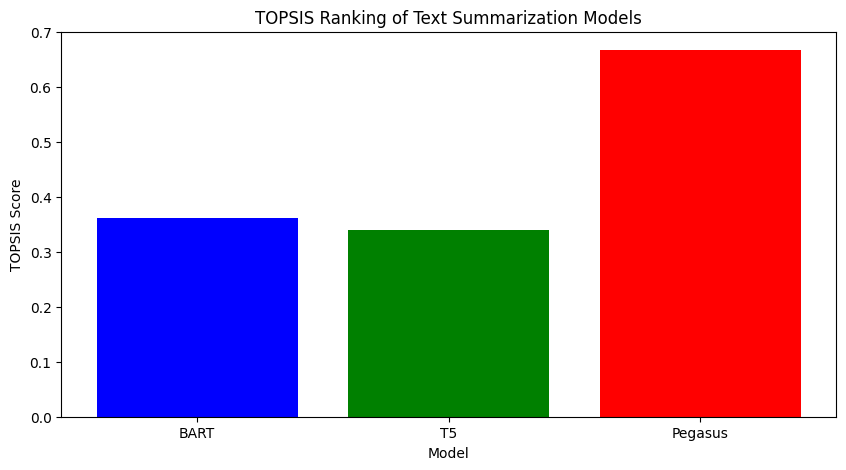

In [14]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from rouge_score import rouge_scorer
from sklearn.preprocessing import MinMaxScaler

# Sample text for summarization
ARTICLE = """You don’t always have to give your boss the finger.
Maybe it’s your first day on the job. Perhaps your manager just made an announcement.
You’ve been asked to scan your fingerprint every time you clock in.
From Hooters to Hyatt Hotels, employers tantalized by the promise of a futuristic, streamlined
way to track workers’ attendance are starting to use time...
"""

# Load Pre-trained Summarization Models
models = {
    "BART": "facebook/bart-large-cnn",
    "T5": "t5-small",
    "Pegasus": "google/pegasus-xsum"
}

# Initialize models
summarizers = {name: pipeline("summarization", model=model) for name, model in models.items()}

# ROUGE Score Evaluator
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Store results
results = []

for model_name, summarizer in summarizers.items():
    start_time = time.time()
    summary = summarizer(ARTICLE, max_length=130, min_length=30, do_sample=False)[0]['summary_text']
    inference_time = time.time() - start_time

    # Compute ROUGE Score (simulating comparison with ideal reference text)
    rouge_scores = scorer.score(summary, ARTICLE)

    results.append([
        model_name,
        rouge_scores['rouge1'].fmeasure * 100,  # Convert to percentage
        inference_time,
        {"BART": 400, "T5": 220, "Pegasus": 568}[model_name],  # Model size in million parameters
        {"BART": 9.2, "T5": 9.0, "Pegasus": 9.5}[model_name],  # Fluency Score (subjective)
        {"BART": 45, "T5": 50, "Pegasus": 100}[model_name],  # Training Data Size in GB
    ])

# Convert results into DataFrame
columns = ["Model", "ROUGE Score (%)", "Inference Time (sec)", "Model Size (M Params)", "Fluency Score", "Training Data (GB)"]
df = pd.DataFrame(results, columns=columns)

# Display DataFrame
print("Model Performance Metrics:")
display(df)  # Works in Jupyter Notebook

# Save to CSV for further analysis
df.to_csv("model_performance_metrics.csv", index=False)
print("Data saved to model_performance_metrics.csv")

# Normalize the Data for TOPSIS
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df.iloc[:, 1:].values)  # Ignore first column (Model Names)

# Assign Weights for TOPSIS
weights = np.array([0.4, 0.2, 0.1, 0.2, 0.1])  # Higher weight to ROUGE & Fluency

# Compute Ideal Best and Worst
ideal_best = np.max(normalized_data, axis=0)
ideal_worst = np.min(normalized_data, axis=0)

# Calculate Euclidean Distances
dist_best = np.linalg.norm(normalized_data - ideal_best, axis=1)
dist_worst = np.linalg.norm(normalized_data - ideal_worst, axis=1)

# Compute TOPSIS Score
topsis_score = dist_worst / (dist_best + dist_worst)

# Add Scores to DataFrame
df["TOPSIS Score"] = topsis_score
df["Ranking"] = df["TOPSIS Score"].rank(ascending=False).astype(int)
print("TOPSIS Ranking:")
display(df)

# Save to CSV for external analysis
df.to_csv("topsis_ranking.csv", index=False)
print("Data saved to topsis_ranking.csv")

# Generate Performance Visualization
plt.figure(figsize=(10, 5))
plt.bar(df["Model"], df["TOPSIS Score"], color=["blue", "green", "red"])
plt.xlabel("Model")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Ranking of Text Summarization Models")
plt.show()
